### Libraries and Dependencies

In [75]:
from torchmetrics import PearsonCorrCoef
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, accuracy_score
import torch
import matplotlib.pyplot as plt
import warnings
import time
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

1. (10 puntos) Particione los datos en 80% datos de entrenamiento y el restante 20% en datos de prueba. Para ese 20% de datos de prueba, reporte la tasa de aciertos y el F1-score para la clase ataque, para 30 corridas, usando todos los atributos del dataset. Como clasificador, implemente por su cuenta el algoritmo de minimos cuadrados. Los atributos categoricos deben ser representados usando la codificacion one-hot-vector. 

### One-Hot-Vector Codification

In [76]:
"""
This is the formatted code for the one-hot-vector encoding of the data. 
Only necessary code was included. 
"""

# Read data frame
df = pd.read_csv('UNSW_NB15_training-set.csv')


def basic_pre_processing():
    list_drop = ['id', 'attack_cat']
    df.drop(list_drop, axis=1, inplace=True)


def codification_cat_data():
    X = df.iloc[:, :-1]
    X.head()
    df_cat = df.select_dtypes(exclude=[np.number])
    DEBUG = 0
    for feature in df_cat.columns:
        if DEBUG == 1:
            print(feature)
            print('nunique = ' + str(df_cat[feature].nunique()))
            print("Is the cardinality higher than 6? ", df_cat[feature].nunique() > 6)
            print("Number of preserved records: ", sum(df[feature].isin(df[feature].value_counts().head().index)))
            print("New categories: (- takes the rest of categories)", df[feature].value_counts().head().index)
            print('----------------------------------------------------')
        if df_cat[feature].nunique() > 6:
            df[feature] = np.where(df[feature].isin(df[feature].value_counts().head().index), df[feature], '-')


def perform_codification():
    basic_pre_processing()
    codification_cat_data()
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1, 2, 3])], remainder='passthrough')
    X = np.array(ct.fit_transform(X))
    return X, y

### Square Means Classification

In [77]:
X, y = perform_codification()

def split_dataset(data, tags, test_size=0.20, random_state=None):
    """
    Function to partition the dataset.
    Default 80% train and 20% test.
    :returns: x_train, x_test, y_train, y_test
    """
    x_train, x_test, y_train, y_test = train_test_split(data, tags, test_size=test_size, random_state=random_state)
    return x_train, x_test, y_train, y_test


def get_optimum_w_square_means(t, x):
    """
    Function to obtain the optimal w for t (tags) and x (data).
    :returns: optimal w
    """
    m_pinv = torch.pinverse(x)
    w_opt = m_pinv.mm(t)
    return w_opt


def evaluate_model_original(data, w, activation_function=False):
    """
    Function to evaluate the model.
    It consists of the dot product between the data and the optimum w.
    If the result is greater than zero then the class is 1. Otherwise, the class is 0.
    :returns: the estimated tags.
    """
    y_out = data.mm(w)
    if activation_function:
        y_out[y_out >= 0] = 1
        y_out[y_out < 0] = 0
    t_estimated = y_out
    return t_estimated


def evaluate_mean_square_error(t, t_estimated):
    """
    Calculates the mean squared error for the tags and the estimated tags of the model.
    :return: mean squared error
    """
    error = torch.norm(t - t_estimated, 2) / (2 * t.shape[0])
    return error

### 30 Runs

In [87]:
def run_30():
    """
    Partitions the data, calculates the optimum w, and returns the error, accuracy, and f1 scores.
    It performs this process 30 times.
    :return: a log of the results.
    """
    log = {}
    for i in range(30):
        x_train, x_test, y_train, y_test = split_dataset(X, y)

        # Training model
        train = torch.tensor(x_train)
        targets = torch.tensor(y_train.to_numpy()).unsqueeze(1).to(torch.float64)
        w_opt = get_optimum_w_square_means(targets, train)

        # Testing model
        test = torch.tensor(x_test)
        test_targets = torch.tensor(y_test.to_numpy()).unsqueeze(1).to(torch.float64)
        targets_estimated = evaluate_model_original(test, w_opt, activation_function=True)

        # Calculating error, accuracy and f1 score
        error = evaluate_mean_square_error(test_targets, targets_estimated)
        accuracy = accuracy_score(test_targets, targets_estimated)
        f1s = f1_score(test_targets, targets_estimated, average='weighted')

        # Saving results in the log
        log[f"Run #{i}"] = {'error': round(error.item(), 4), 'accuracy': accuracy, 'f1s': f1s}
    return log

log = run_30()
log_data_frame = pd.DataFrame.from_dict(log)
pd.DataFrame.transpose(log_data_frame)

,error,accuracy,f1s
Run #0,0.0022,0.670007,0.611838
Run #1,0.0022,0.666727,0.607852
Run #2,0.0023,0.664480,0.605976
Run #3,0.0022,0.668488,0.611080
Run #4,0.0022,0.668428,0.610609
Run #5,0.0023,0.663205,0.602942
Run #6,0.0022,0.671161,0.614190
Run #7,0.0022,0.668914,0.610730
Run #8,0.0022,0.671221,0.612669
Run #9,0.0022,0.666727,0.608839


2. (30 puntos) Implemente la funcion calculate_expected_calibration_error(X, y, uncertainties), el cual tome como entrada un conjunto de observaciones junto con sus etiquetas correctas (ground truth) y sus cuantificaciones de incertidumbre, y calcule el expected calibration error (ECE) según lo explicado en el material de apoyo.

    \
    a) Diseñe y documente los resultados de al menos dos pruebas unitarias.  

### ECE calculate_expected_calibration_error

In [79]:
def calculate_expected_calibration_error(x_in, y_real, uncertainties, y_predicted, n_bins=10, plot=True):
    # Calculate bins ranges
    bins = create_bins_and_append_prediction_to_values(uncertainties, y_real, y_predicted, n_bins)
    # Calculate the accuracy of each bin
    accuracy_bins = torch.tensor([calculate_accuracy_bin(bins[bin_num]) for bin_num in bins])

    # Calculate the average uncertainty of each bin
    bin_average_uncertainty = [sum(data[0] for data in bins[in_bin]) / len(bins[in_bin]) for in_bin in bins]
    bin_average_uncertainty = torch.tensor(bin_average_uncertainty)

    # bin_average_uncertainty -> Acts as X | accuracy_bins -> Acts as Y

    # Pearson coefficient calculation

    # Method 2: calculation with torch metrics
    pearson = PearsonCorrCoef()
    pearson_corr = pearson(bin_average_uncertainty, accuracy_bins).nan_to_num().item()

    # Plotting
    if plot:
        plot_bin_accuracy_chart(bins, accuracy_bins, bin_average_uncertainty)

    ece = 1 - abs(pearson_corr)
    return max(0, min(ece, 1))


def create_bins_and_append_prediction_to_values(uncertainties, y_real, y_predicted, n_bins):
    # Convert uncertainties to numpy array for quantile calculations
    uncertainties_np = torch.tensor(uncertainties).to(torch.float64)

    # Calculate quantiles to define bin edges
    quantiles = torch.linspace(0, 1, n_bins + 1).to(torch.float64)
    bin_edges = torch.quantile(uncertainties_np, quantiles)

    # Create bins
    bins = {i: [] for i in range(n_bins)}

    # Assign values to bins
    for uncertainty, real_label, predicted_label in zip(uncertainties, y_real, y_predicted):
        # Determine the bin index by finding the first bin edge that is greater than the uncertainty
        index = torch.searchsorted(bin_edges, uncertainty, right=True) - 1
        index = min(index.item(), n_bins - 1)  # Ensure the value equal to max_val is included in the last bin
        prediction = (predicted_label >= 0).to(torch.float64) == real_label
        bins[index].append((uncertainty, prediction))

    return bins


def calculate_accuracy_bin(in_bin):
    if len(in_bin) == 0:
        return 0
    correct_predictions = 0
    for value in in_bin:
        correct_predictions += 1 if value[1] else 0
    total_predictions = len(in_bin)
    accuracy = (correct_predictions / total_predictions) * 100
    return accuracy


def plot_bin_accuracy_chart(bins, accuracy_bins, bin_average_uncertainty):
    bin_edges_visual = torch.linspace(min(bins[0])[0].item(), max(bins[len(bins) - 1])[0].item(), steps=len(bins) + 1)
    bin_centers_visual = 0.5 * (bin_edges_visual[:-1] + bin_edges_visual[1:])

    # Create the figure and axis.
    fig, ax = plt.subplots(figsize=(10, 7))

    # Plot a dot in the middle of each bin.
    for center, value in zip(bin_centers_visual, accuracy_bins):
        ax.plot(center, value, 'ro')  # 'ro' for red circle

    # Print average uncertainty for each bin in x-axis.
    custom_ticks = [center for center in bin_centers_visual]
    ax.set_xticks(custom_ticks)
    ax.set_xticklabels([f"#{bin_num + 1}" for bin_num in range(len(bin_average_uncertainty))])

    # Add a line for each bin edge
    for edge in bin_edges_visual:
        ax.axvline(edge, color='red', linestyle='dashed', linewidth=1)

    # Set axis labels and title.
    ax.set_xlabel('')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy per Bin for ECE calculation')

    # Set y-axis limits to fit the range of bin values.
    ax.set_ylim(-10, 110)

    # Print bin number in secondary x-axis.
    ax2 = ax.twiny()
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 17))
    ax2.set_xlabel('Bin Number and Average Uncertainty (Variance)')
    ax2.set_xticks(custom_ticks)
    custom_labels = [f"{"{:.1e}".format(round(bin_num.item(), 5))}" for index, bin_num in
                     enumerate(bin_average_uncertainty)]
    ax2.set_xticklabels(custom_labels)
    ax2.set_xlim(ax.get_xlim())
    ax2.spines['bottom'].set_visible(False)

    plt.show()

### Unit Tests

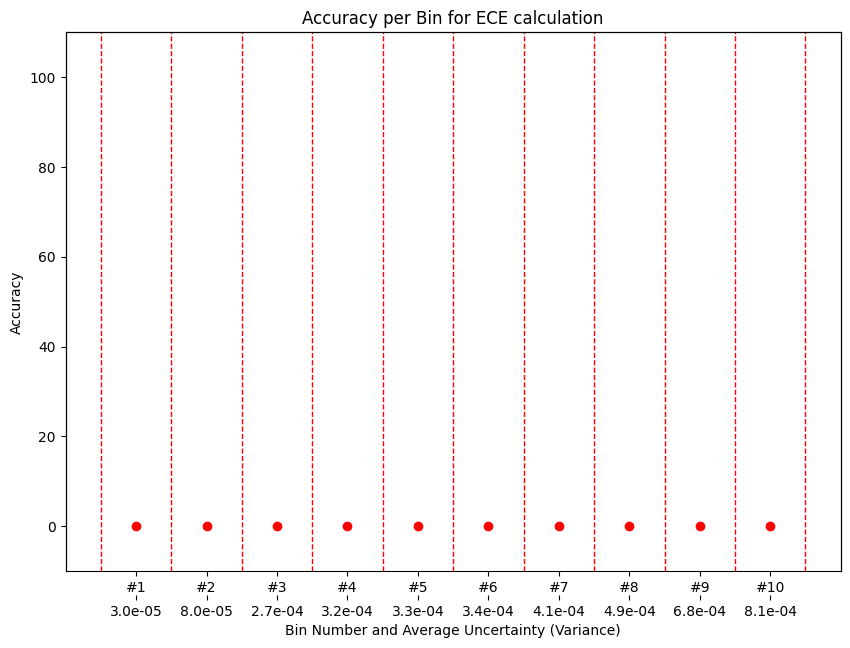

Worse Calibration Test:
Result: Passed! 
Calculated ECE: 1.0 
Expected: 1.0



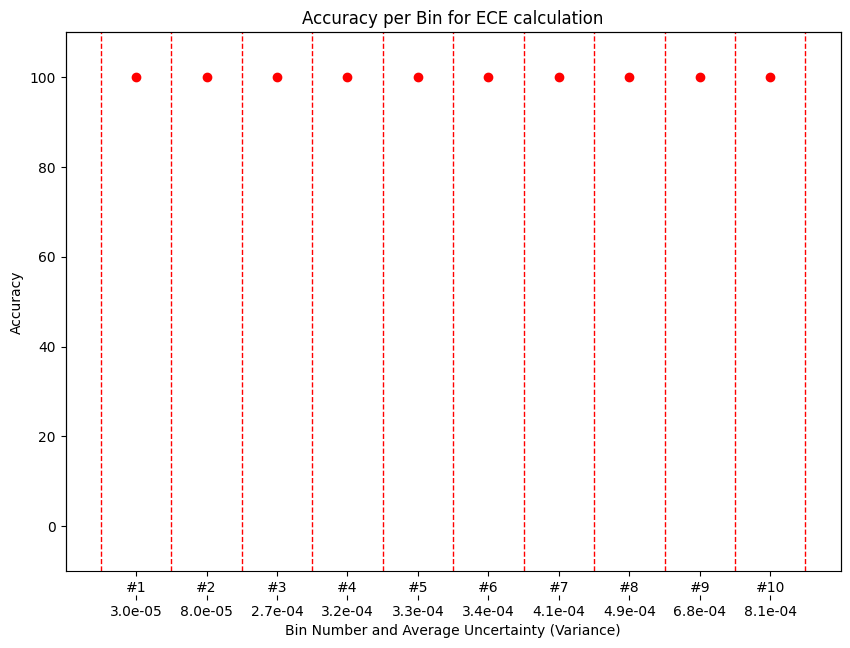

Perfect Calibration Test:
Result Passed! 
Calculated ECE: 0 
Expected: 0


In [80]:
def test_calculate_expected_calibration_error_worse_calibration():
    example_variances = torch.tensor([0.000814, 0.000343, 0.000491, 0.000273, 0.000321, 0.000325, 0.000034, 0.000678, 0.000084, 0.00041])
    example_y_outputs = torch.tensor([0.871897, - 0.095776, - 0.199759, 1.157389, 0.4576, 0.455021, 0.95016, 0.559645, 0.901524, 0.493699])
    example_y_real = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
    ece = calculate_expected_calibration_error(None, example_y_real, example_variances, example_y_outputs, plot=True)
    assert ece == 1
    print("Worse Calibration Test:")
    print(f"Result: Passed! \nCalculated ECE: {ece} \nExpected: 1.0")


def test_calculate_expected_calibration_error_perfect_calibration():
    example_variances = torch.tensor([0.000814, 0.000343, 0.000491, 0.000273, 0.000321, 0.000325, 0.000034, 0.000678, 0.000084, 0.00041])
    example_y_outputs = torch.tensor([0.871897, -0.095776, -0.199759, 1.157389, -0.4576, -0.455021, 0.95016, 0.559645, 0.901524, 0.493699])
    example_y_real = [1, 0, 0, 1, 0, 0, 1, 1, 1, 1]
    ece = calculate_expected_calibration_error(None, example_y_real, example_variances, example_y_outputs, plot=True)
    assert ece == 0
    print("Perfect Calibration Test:")
    print(f"Result Passed! \nCalculated ECE: {ece} \nExpected: 0")
    
test_calculate_expected_calibration_error_worse_calibration()
print("\n")
test_calculate_expected_calibration_error_perfect_calibration()

3. (30 puntos) Implemente el algoritmo de estimacion de incertidumbre de ensamble detallado en el material de apoyo. Para ello, hagalo en la funcion quantify_uncertainty_ensemble(x, model, N = 10) el cual cuantifique la incertidumbre para una entrada $\overrightarrow{x}\in\mathbb{R}^{D}$, y retorne tal resultado. Hagalo usando modelos de minimos cuadrados de clasificacion. Utilice la salida del producto punto (sin pasar por la funcion de activacion del modelo), para obtener los puntajes de los miembros del ensamble. Se recomienda dividir la implementacion de esta funcion en la funcion train_ensemble la cual entrene los miembros del ensamble, y run_ensemble_uq la cual tome el ensamble anteriormente construido y evalue la varianza de las salidas. 
    \
    a) Diseñe y documente los resultados de al menos dos pruebas unitarias.

###  Uncertainty Ensemble quantify_uncertainty_ensemble

In [81]:
def quantify_uncertainty_ensemble(x_test, model, n_ensemble=10, ensemble=None, random_state=None):
    if ensemble is None:
        ensemble = train_ensemble(n_ensemble, random_state=random_state)
    y_outputs = run_ensemble_uq(x_test, ensemble, model)
    y_outputs_stacked = torch.stack(y_outputs).squeeze(-1).t()
    variances = []
    predictions = []
    for y_out in y_outputs_stacked:
        var_xi = torch.var(y_out)
        predicted_y = torch.mean(y_out)
        variances.append(var_xi)
        predictions.append(predicted_y)
    return torch.tensor(variances), torch.tensor(predictions)


def train_ensemble(n, x_train=None, y_train=None, random_state=None):
    if x_train is None or y_train is None:
        x_train, _, y_train, _ = split_dataset(X, y, test_size=0.3, random_state=random_state)
    train_splits = kfold_split(x_train, y_train.to_numpy(), n, random_state=random_state)
    ensembles = []
    for split in train_splits:
        x_split = torch.tensor(split[0])
        y_split = torch.tensor(split[1]).unsqueeze(1).to(torch.float64)
        w_opt = get_optimum_w_square_means(y_split, x_split)
        ensembles.append(w_opt)
    return ensembles


def kfold_split(features, labels, n_splits, random_state=None):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)  # Using a random state for reproducibility
    # This will store the training subsets and their corresponding labels
    subsets = []

    for train_index, test_index in kf.split(features):
        feature_subset = features[test_index]
        label_subset = labels[test_index]
        subsets.append((feature_subset, label_subset))

    return subsets


def run_ensemble_uq(x, ensemble, model):
    y_outputs = [model(x, indv_ensemble) for indv_ensemble in ensemble]
    return y_outputs

### Unit Tests

In [82]:
def test_quantify_uncertainty_ensemble_individual_entry():
    # Splitting dataset with random state 42 to ensure reproducibility
    x_train, x_test, y_train, y_test = split_dataset(X, y, random_state=42)
    # Individual entry:
    entry = torch.tensor(x_test[0]).unsqueeze(-1).t().to(torch.float64)
    variance, y_outputs = quantify_uncertainty_ensemble(entry, evaluate_model_original, n_ensemble=10, random_state=42)
    variance = round(variance.item(), 3)
    y_outputs = round(y_outputs.item(), 3)
    assert variance == 0.002
    assert y_outputs == 0.011
    print("Single Entry Test:")
    print(f"Result: Passed! \nCalculated Variance: {variance} \nExpected: {0.002}")
    print(f"Estimated Output: {y_outputs} \nExpected: {0.011}")


def test_quantify_uncertainty_ensemble_multiple_entry():
    # Splitting dataset with random state 42 to ensure reproducibility
    x_train, x_test, y_train, y_test = split_dataset(X, y, random_state=42)
    # Gathering entries:
    x_test = torch.tensor(x_test)
    entries = torch.stack([x_test[0], x_test[1], x_test[2]])
    variance, y_outputs = quantify_uncertainty_ensemble(entries, evaluate_model_original, n_ensemble=10, random_state=42)
    variance = [round(x, 4) for x in list(variance.numpy())]
    y_outputs = [round(x, 4) for x in list(y_outputs.numpy())]
    assert variance == [0.0024, 0.0001, 0.0004]
    assert y_outputs == [0.0108, 0.9777, 0.8247]
    print("Multiple Entry Test:")
    print(f"Result: Passed! \nCalculated Variance: {variance} \nExpected: [0.0024, 0.0001, 0.0004]")
    print(f"Estimated Outputs: {y_outputs} \nExpected: [0.0108, 0.9777, 0.8247]")
    
test_quantify_uncertainty_ensemble_individual_entry()
print("\n")
test_quantify_uncertainty_ensemble_multiple_entry()

Single Entry Test:
Result: Passed! 
Calculated Variance: 0.002 
Expected: 0.002
Estimated Output: 0.011 
Expected: 0.011

Multiple Entry Test:
Result: Passed! 
Calculated Variance: [0.0024, 0.0001, 0.0004] 
Expected: [0.0024, 0.0001, 0.0004]
Estimated Outputs: [0.0108, 0.9777, 0.8247] 
Expected: [0.0108, 0.9777, 0.8247]


4. (30 puntos) Documente las siguientes pruebas: mida el ECE y el tiempo de ejecucion usando la funcion anterior, y un conjunto de datos de prueba correspondiente al 30% de los datos provistos. El 70% de los datos restantes se usaran para entrenar el o los modelos necesarios. Realice lo anterior para las siguientes configuraciones:
\
    a) N=10. 
\
    b) N=100
\
    c) N=1000
\
    Realice 10 particiones de test/training para calcular el ECE promedio por cada configuracion. Reporte el ECE promedio, y desviacion estandar de cada configuracion probada. Grafique los resultados de forma ordenada y clara, y comentelos. 

In [83]:
def run_tests(n):
    start_time = time.time()

    x_train, x_test, y_train, y_test = split_dataset(X, y, test_size=0.30, random_state=42)
    test_partitions = kfold_split(x_test, y_test.to_numpy(), n_splits=10, random_state=42)
    train_partitions = kfold_split(x_train, y_train.to_numpy(), n_splits=10, random_state=42)

    trained_ensemble = train_ensemble(n, x_train, y_train, random_state=42)
    test_part_avg_ece, test_part_std = calculate_avg_ece_and_std_partition(test_partitions, trained_ensemble, "Test")
    train_part_avg_ece, train_part_std = calculate_avg_ece_and_std_partition(train_partitions, trained_ensemble,
                                                                             "Train")

    end_time = time.time()
    elapsed_time = end_time - start_time
    
    results = {f"N={n}": {"Elapsed time": elapsed_time, "Test Partition Average ECE": round(test_part_avg_ece.item(), 4),
                   "Test Partition Std": round(test_part_std.item(), 4),
                   "Train Part Average ECE": round(train_part_avg_ece.item(), 4), "Train Partition Std": round(train_part_std.item(), 4)}}

    return results
        

def calculate_avg_ece_and_std_partition(partition, ensemble, partition_label):
    test_partition_ece = []
    for part in partition:
        x_partition = torch.tensor(part[0])
        y_real_partition = torch.tensor(part[1]).unsqueeze(1).to(torch.float64)
        variance, y_outputs = quantify_uncertainty_ensemble(x_partition, evaluate_model_original, ensemble=ensemble)
        ece = calculate_expected_calibration_error(x_partition, y_real_partition, variance, y_outputs, plot=False)
        test_partition_ece.append(ece)
    test_partition_ece = torch.tensor(test_partition_ece)
    average_ece = torch.mean(test_partition_ece)
    std = torch.std(test_partition_ece)
    plot_results(test_partition_ece, partition_label, average_ece, std, len(ensemble))
    return average_ece, std


def plot_results(test_partition_ece, partition_label, average_ece, std, n_configuration):
    x_linspace = torch.linspace(0, len(test_partition_ece), steps=len(test_partition_ece) + 1)
    y_centers = 0.5 * (x_linspace[:-1] + x_linspace[1:])

    # Create the figure and axis.
    fig, ax = plt.subplots(figsize=(10, 7))

    # Plot a dot in the middle.
    for center, value in zip(y_centers, test_partition_ece):
        ax.plot(center, value, 'ro')  # 'ro' for red circle

    # Print labels.
    custom_ticks = [center for center in y_centers]
    ax.set_xticks(custom_ticks)
    ax.set_xticklabels([f"#{bin_num + 1}" for bin_num in range(len(test_partition_ece))])

    # Add a line for each partition.
    for edge in x_linspace:
        ax.axvline(edge, color='red', linestyle='dashed', linewidth=1)

    ax.set_xlabel('Partition number')
    ax.set_ylabel('ECE')
    ax.set_title(f'{partition_label} Partition ECE values | Configuration N={n_configuration}'
                 f' \n Average ECE: {round(average_ece.item(), 4)} '
                 f'| Standard Deviation: {round(std.item(), 4)}')

    plt.show()

### Testing with:
### N = 10

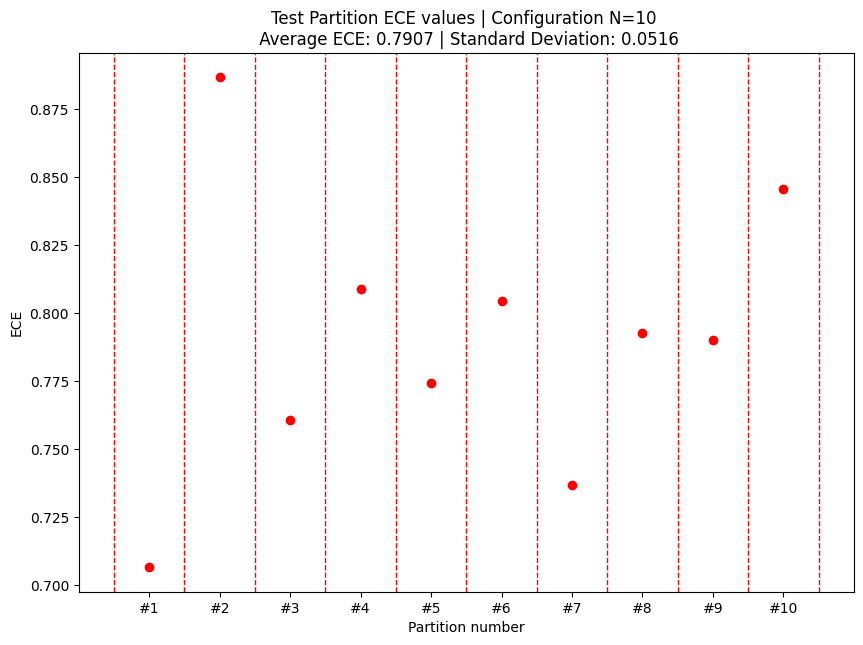

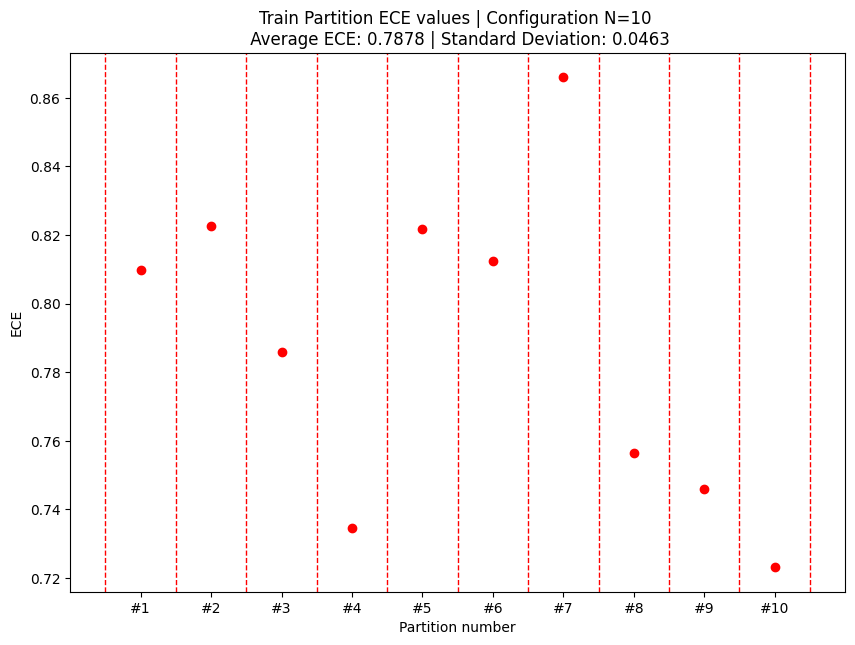

Results for configuration N=10


,N=10
Elapsed time,8.028828
Test Partition Average ECE,0.790700
Test Partition Std,0.051600
Train Part Average ECE,0.787800
Train Partition Std,0.046300


In [84]:
results = run_tests(10)
results_data_frame = pd.DataFrame.from_dict(results)
print(f"Results for configuration N=10")
results_data_frame

### Testing with:
### N = 100

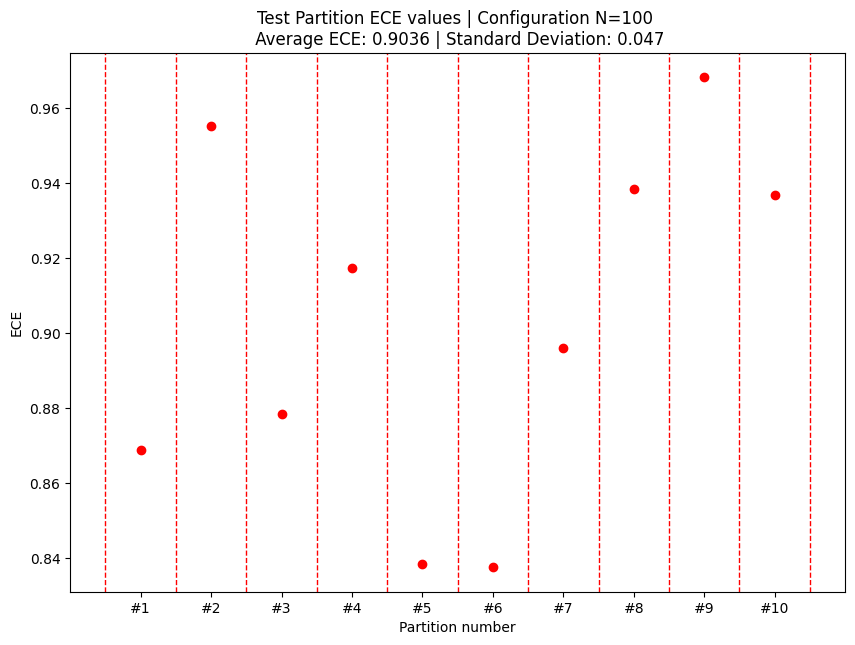

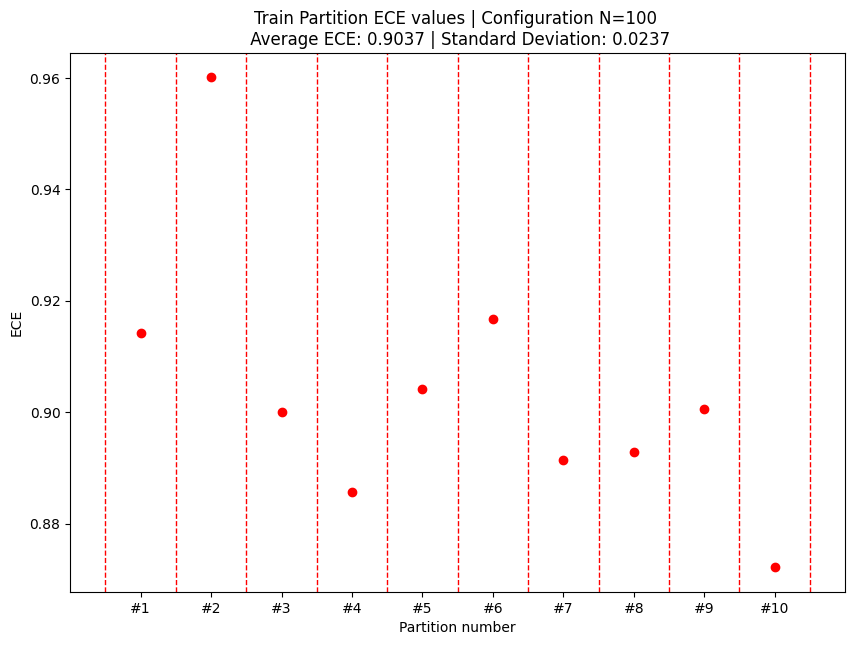

Results for configuration N=100


,N=100
Elapsed time,8.149271
Test Partition Average ECE,0.903600
Test Partition Std,0.047000
Train Part Average ECE,0.903700
Train Partition Std,0.023700


In [85]:
results = run_tests(100)
results_data_frame = pd.DataFrame.from_dict(results)
print(f"Results for configuration N=100")
results_data_frame

### Testing with:
### N = 1000

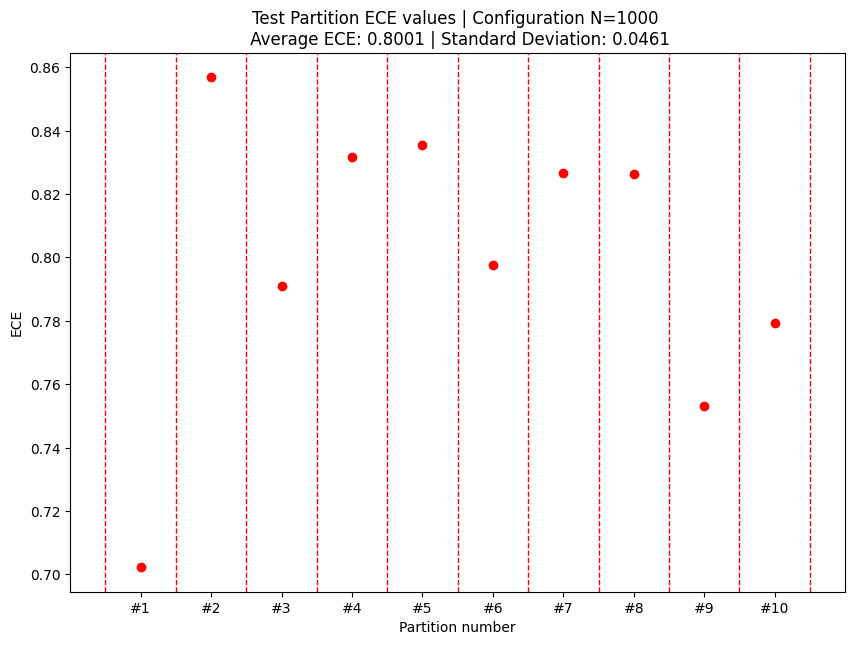

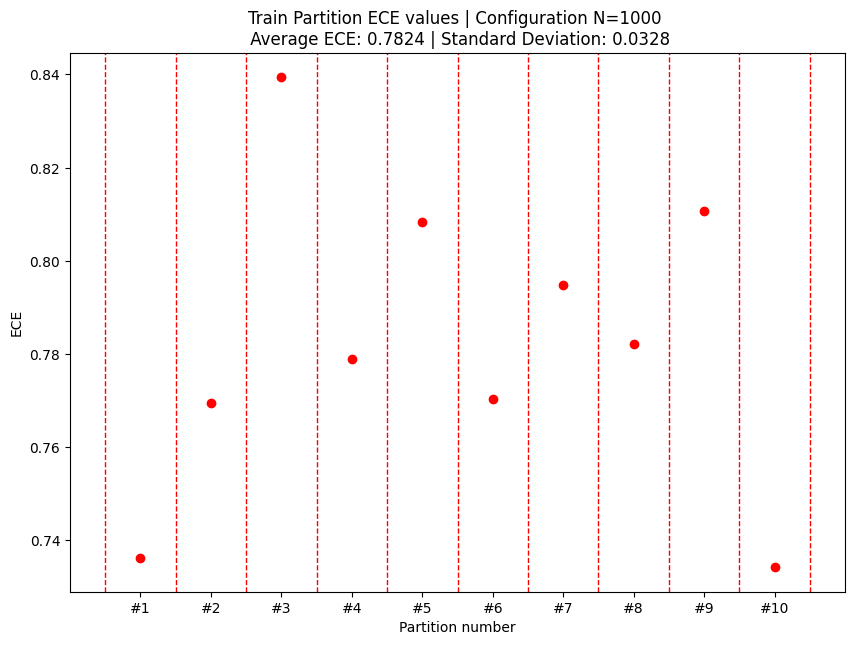

Results for configuration N=1000


,N=1000
Elapsed time,11.707747
Test Partition Average ECE,0.800100
Test Partition Std,0.046100
Train Part Average ECE,0.782400
Train Partition Std,0.032800


In [86]:
results = run_tests(1000)
results_data_frame = pd.DataFrame.from_dict(results)
print(f"Results for configuration N=1000")
results_data_frame